# Cats-vs-Dogs - Kaggle Challenge - Binary Image Classification using Pytorch
This workbook is my attempt to solve the [Kaggle Cats-vs-Dogs challenge](https://www.kaggle.com/c/dogs-vs-cats) using Pytorch. Here I create a CNN, which is improved using Image Augmentation and Transfer Learning techniques, specifically using the VGG16 and Resnet18 models.

<font color='firebrick'>It is recommended that you run this notebook on a GPU only, like ones available on Google Colab or Kaggle</font>

<center><img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3362/media/woof_meow.jpg"></center>


**NOTE**:
* Data (images) for this problem can be dowloaded from Kaggle to the /tmp folder - I will be using the `tongpython/cat-and-dog` dataset
* We'll use the Kaggle API to download the dataset. You'll first need to download your `kaggle.json` file from Kaggle.com and use the Kaggle API

@see: [Medium Article](https://towardsdatascience.com/10-tips-for-a-better-google-colab-experience-33f8fe721b82#8c1e) on how to keep Colab notebook from disconnecting -- see point #7. You will need this trick for this notebook as training is run for >75 epochs!

## Using a custom trained model
In this section we'll cross-train a hand-crafted Pytorch CNN and evaluate its performance on test imageset.

In [ ]:
# We use torchmetrics, which is not installed by default on Collaboratory
!pip install torchmetrics --quiet

     |████████████████████████████████| 419 kB 8.3 MB/s 


In [ ]:
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = True

import os

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    gdrive_path = os.path.join(gdrive_mount_point, "My Drive/")
    print('Your Google Drive is mounted at ', gdrive_path)
    COLAB_NOTEBOOKS_PATH = os.path.join(gdrive_path, "Colab Notebooks","Pytorch")
    
    if os.path.exists(COLAB_NOTEBOOKS_PATH):
        print('You Colab notebooks are available at ', COLAB_NOTEBOOKS_PATH)
    
        # display list of files
        #!ls '/content/drive/My Drive/Colab Notebooks/'

        # append our Google Drive folder to module search 
        # **NOTE:** comment this line out if you are NOT running this notebook on Google Colab
        import sys
        #sys.path.append("/content/drive/My Drive/Colab Notebooks/")
        sys.path.append(COLAB_NOTEBOOKS_PATH)
        print('NOTE: {} is appended to sys.path!'.format(COLAB_NOTEBOOKS_PATH))
        # and test it
        import pytorch_toolkit as pytk
        MODEL_SAVE_DIR = os.path.join(COLAB_NOTEBOOKS_PATH, "model_states")
        #IMAGES_ZIP_DIR = "/content/drive/My Drive/Colab Notebooks/data/kaggle/malaria"
    else:
        raise IOError("Unable to mount Google Drive!")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    #IMAGES_ZIP_DIR = "./images/kaggle/malaria"

print(f"Model states will be saved to {MODEL_SAVE_DIR}")
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

Mounted at /content/drive/
Your Google Drive is mounted at  /content/drive/My Drive/
You Colab notebooks are available at  /content/drive/My Drive/Colab Notebooks/Pytorch
NOTE: /content/drive/My Drive/Colab Notebooks/Pytorch is appended to sys.path!
Model states will be saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states


In [ ]:
# download the data from Kaggle using Kaggle API
# Run this cell to copy the uploaded kaggle.json file to ~/.kaggle/kaggle.json 
# Kaggle expects the token file to be located here!!
!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/Colab Notebooks/kaggle.json" ~/.kaggle/
# give "me" full access to kaggle.json (i.e. read/write & execute)
!chmod 600 ~/.kaggle/kaggle.json
# confirm that ~/.kaggle folder has kaggle.json file
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog -p /tmp

 96% 209M/218M [00:02<00:00, 74.5MB/s]
100% 218M/218M [00:02<00:00, 97.2MB/s]


In [ ]:
!unzip -q -o /tmp/cat-and-dog.zip -d /tmp

In [ ]:
TRAIN_IMAGES_BASE_PATH = os.path.join('/tmp', 'training_set', 'training_set')
TEST_IMAGES_BASE_PATH = os.path.join('/tmp', 'test_set', 'test_set')
assert os.path.exists(TRAIN_IMAGES_BASE_PATH), f"FATAL: {TRAIN_IMAGES_BASE_PATH} does not exit!"
assert os.path.exists(TEST_IMAGES_BASE_PATH), f"FATAL: {TEST_IMAGES_BASE_PATH} does not exit!"

### Standard Imports

In [ ]:
import warnings

warnings.filterwarnings('ignore')

import sys
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from PIL import Image

# Pytorch imports
import torch

print('Using Pytorch version: ', torch.__version__)
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch import optim

# My helper functions for training/evaluating etc.
import pytorch_toolkit as pytk

# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn')
sns.set(style='darkgrid', context='notebook', font_scale=1.20)

SEED = pytk.seed_all()

Using Pytorch version:  1.11.0+cu113


### Downloading & Preparing the Data

In [ ]:
# hyper parameters
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 150, 150, 3, 2
NUM_EPOCHS, BATCH_SIZE, LEARNING_RATE, L2_REG = 100, 128, 0.001, 0.001
MODEL_SAVE_NAME = 'cat_or_dog.pyt'
MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, MODEL_SAVE_NAME)
print(f"Model state will be saved to {MODEL_SAVE_PATH}")

Model state will be saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/cat_or_dog.pyt


In [ ]:
def load_data(test_perc=0.2):
    """
    load the data using datasets API. We also split the test_dataset into 
    cross-val/test datasets using 80:20 ration
    """
    mean, std = 0.5, 0.5

    xforms = {
        'train': transforms.Compose([
            transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
            transforms.RandomAffine(degrees=(-40, 40), translate=(0.20, 0.20), 
                                    scale=(0.8, 1.2), shear=0.20),
            transforms.RandomHorizontalFlip(0.30),
            # transforms.RandomVerticalFlip(0.30),
            transforms.CenterCrop((IMAGE_WIDTH, IMAGE_HEIGHT)),
            transforms.ToTensor(),
            #transforms.Normalize(mean, std)
        ]),
        'val_or_test': transforms.Compose([
            transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
            transforms.CenterCrop((IMAGE_WIDTH, IMAGE_HEIGHT)),
            transforms.ToTensor(),
            #transforms.Normalize(mean, std)
        ])
    }

    train_dataset = datasets.ImageFolder(TRAIN_IMAGES_BASE_PATH, transform=xforms['train'])
    test_dataset = datasets.ImageFolder(TEST_IMAGES_BASE_PATH, transform=xforms['train'])
    num_images = len(test_dataset)
    num_test_images = int(test_perc * num_images)
    num_val_images = num_images - num_test_images
    print(f"get_data(): {len(test_dataset)} test images split to {num_val_images} eval & {num_test_images} test images")
    val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [num_val_images, num_test_images])
    return train_dataset, val_dataset, test_dataset

In [ ]:
def display_sample(images, labels, predictions=None, fig_size=None, num_cols=10, plot_title=None):
    num_images = len(images)
    num_rows = num_images // num_cols
    num_rows = num_rows if (num_images % num_cols == 0) else num_rows + 1

    label_lookup = {
        0: 'Cat',
        1: 'Dog'
    }

    figsize = (18,18) if fig_size is None else fig_size

    with sns.axes_style("whitegrid"):
        sns.set(context='notebook', font_scale=1.20)
        sns.set_style({"font.sans-serif": ["SF Pro Display", "Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        # plt.figure(figsize=figsize)
        fig, ax = plt.subplots(num_rows, num_cols, figsize=figsize,
                               gridspec_kw={"wspace": 0.02, "hspace": 0.25}, squeeze=True)
        fig.tight_layout()
        for row in range(num_rows):
            for col in range(num_cols):
                ax[row, col].axis('off')
                index = row * num_cols + col
                if index < num_images:
                    image = images[index].clip(0.0, 255.0)
                    image = image.transpose((1,2,0))
                    ax[row, col].imshow(image)
                    if predictions is not None:
                        title = label_lookup[labels[index]] if predictions[index] == labels[index] \
                            else label_lookup[predictions[index]] + '/' + label_lookup[labels[index]]
                    else:
                        title = label_lookup[labels[index]]
                    ax[row, col].set_title(title)
        if plot_title is not None:
            plt.suptitle(plot_title)

    plt.show()
    plt.close()

In [ ]:
# (down)load the data
train_dataset, val_dataset, test_dataset = load_data()
print(f"train_dataset: {len(train_dataset)} images - val_dataset: {len(val_dataset)} images " +
      f"test_dataset: {len(test_dataset)} images.")

get_data(): 2023 test images split to 1619 eval & 404 test images
train_dataset: 8005 images - val_dataset: 1619 images test_dataset: 404 images.


images.shape = torch.Size([64, 3, 150, 150]), labels.shape=torch.Size([64])


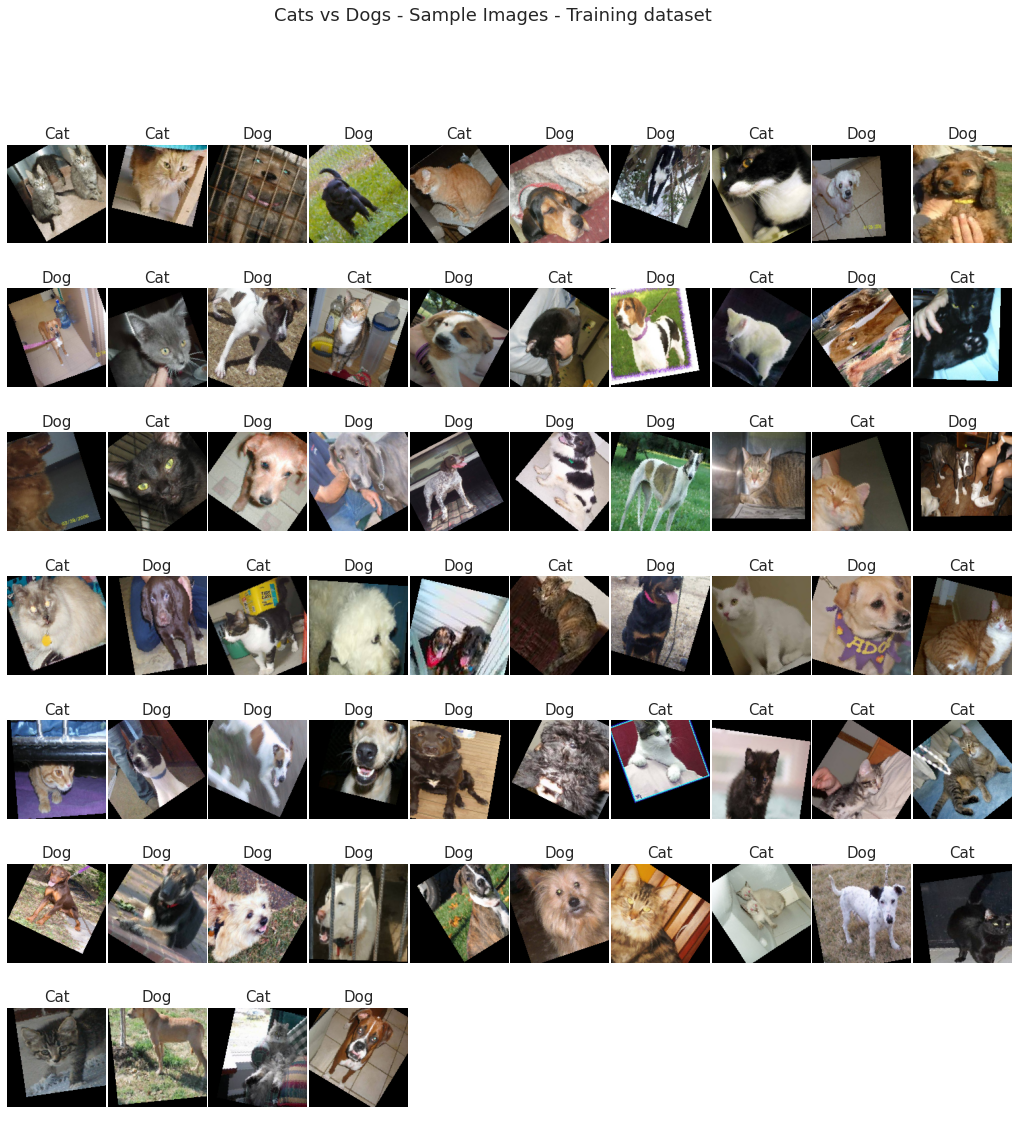

In [ ]:
# display a sample from training dataset, which will show the transforms
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
data_iter = iter(trainloader)
images, labels = data_iter.next()  # fetch first batch of 64 images & labels
print(f'images.shape = {images.shape}, labels.shape={labels.shape}')
#print(f'labels = {labels[:10]}')
display_sample(images.cpu().numpy(), labels.cpu().numpy(), num_cols=10, 
               plot_title='Cats vs Dogs - Sample Images - Training dataset')

### Custom Pytorch Model development

In [ ]:
def build_model(lr=LEARNING_RATE):
    def conv_layer(ino, out, kernel_size=5, stride=1, padding='same'):
        """ a single custom convolutional layer with 2 back-to-back Conv2d layers """
        return nn.Sequential(
            nn.Conv2d(ino, out, kernel_size, stride, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(out),
            nn.Conv2d(out, out, kernel_size, stride, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(out),
            nn.MaxPool2d(2),
        )

    net = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=5, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, kernel_size=5, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2),
        nn.Dropout(0.10),

        nn.Conv2d(32, 64, kernel_size=5, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, kernel_size=5, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),
        nn.Dropout(0.20),

        nn.Conv2d(64, 64, kernel_size=5, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, kernel_size=5, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, kernel_size=5, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),
        nn.Dropout(0.30),

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 128, kernel_size=5, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2),
        nn.Dropout(0.30),

        nn.Flatten(),
        nn.Dropout(0.35),

        nn.Linear(128 * 9 * 9, 1024),
        nn.Dropout(0.20),

        nn.Linear(1024, NUM_CLASSES)
    )

    model = pytk.PytkModuleWrapper(net)
    loss_fn = nn.CrossEntropyLoss()  # nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=L2_REG)
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=['acc'])
    return model, optimizer

In [ ]:
model, optimizer = build_model()
model.summary((NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]           2,432
              ReLU-2         [-1, 32, 150, 150]               0
       BatchNorm2d-3         [-1, 32, 150, 150]              64
            Conv2d-4         [-1, 32, 150, 150]          25,632
              ReLU-5         [-1, 32, 150, 150]               0
       BatchNorm2d-6         [-1, 32, 150, 150]              64
         MaxPool2d-7           [-1, 32, 75, 75]               0
           Dropout-8           [-1, 32, 75, 75]               0
            Conv2d-9           [-1, 64, 75, 75]          51,264
             ReLU-10           [-1, 64, 75, 75]               0
      BatchNorm2d-11           [-1, 64, 75, 75]             128
           Conv2d-12           [-1, 64, 75, 75]         102,464
             ReLU-13           [-1, 64, 75, 75]               0
      BatchNorm2d-14           [-1, 64,

### Training & Evaluating the model

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR, StepLR
#scheduler = ExponentialLR(optimizer, gamma=0.01)
scheduler = StepLR(optimizer, step_size=NUM_EPOCHS//5, gamma=0.1)
hist = model.fit_dataset(train_dataset, validation_dataset=val_dataset, epochs=NUM_EPOCHS,
                         batch_size=BATCH_SIZE, lr_scheduler=scheduler, num_workers=2)

Training on GPU...
Training on 8005 samples, cross-validating on 1619 samples
Epoch (  1/100): (8005/8005) -> loss: 2.4609 - acc: 0.5288 - val_loss: 0.7589 - val_acc: 0.5246 - lr: ['0.00100000']
Epoch (  2/100): (8005/8005) -> loss: 1.5861 - acc: 0.5544 - val_loss: 0.7041 - val_acc: 0.5833 - lr: ['0.00100000']
Epoch (  3/100): (8005/8005) -> loss: 1.2783 - acc: 0.5786 - val_loss: 0.6778 - val_acc: 0.6026 - lr: ['0.00100000']
Epoch (  4/100): (8005/8005) -> loss: 1.1177 - acc: 0.5957 - val_loss: 0.6657 - val_acc: 0.6109 - lr: ['0.00100000']
Epoch (  5/100): (8005/8005) -> loss: 1.0207 - acc: 0.6069 - val_loss: 0.6855 - val_acc: 0.6023 - lr: ['0.00100000']
Epoch (  6/100): (8005/8005) -> loss: 0.9522 - acc: 0.6175 - val_loss: 0.6736 - val_acc: 0.6138 - lr: ['0.00100000']
Epoch (  7/100): (8005/8005) -> loss: 0.9032 - acc: 0.6256 - val_loss: 0.6815 - val_acc: 0.6199 - lr: ['0.00100000']
Epoch (  8/100): (8005/8005) -> loss: 0.8656 - acc: 0.6325 - val_loss: 0.6751 - val_acc: 0.6240 - lr: [

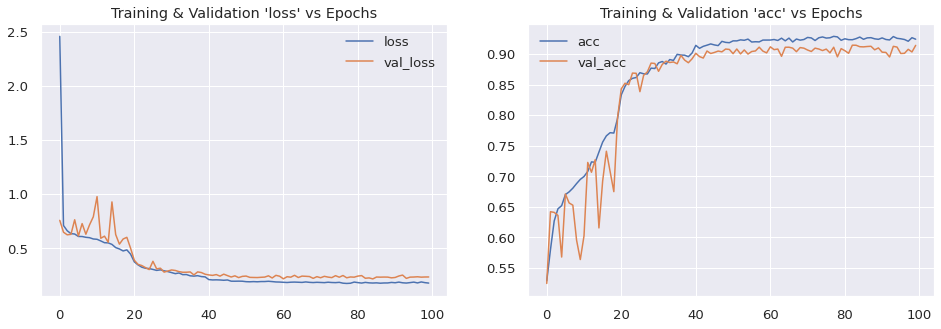

In [ ]:
pytk.show_plots(hist, metric='acc')

In [ ]:
# evaluate performance
print('Evaluating model performance...')
loss, acc = model.evaluate_dataset(train_dataset)
print(f'  Training dataset -> loss: {loss:.4f} - acc: {acc:.4f}')
loss, acc = model.evaluate_dataset(val_dataset)
print(f'  Cross-val dataset -> loss: {loss:.4f} - acc: {acc:.4f}')
loss, acc = model.evaluate_dataset(test_dataset)
print(f'  Test dataset      -> loss: {loss:.4f} - acc: {acc:.4f}')

Evaluating model performance...
Evaluating (8005/8005) -> loss: 0.1641 - acc: 0.9322
  Training dataset -> loss: 0.1641 - acc: 0.9322
Evaluating (1619/1619) -> loss: 0.2307 - acc: 0.9105
  Cross-val dataset -> loss: 0.2307 - acc: 0.9105
Evaluating (404/404) -> loss: 0.2293 - acc: 0.9147
  Test dataset      -> loss: 0.2293 - acc: 0.9147


#### Observations

>Configuration | Training Acc | Cross-val Acc | Test Acc | Observation
>:---|:---:|:---:|:---:|:---|
>**Base Model**|~93-94%|~91-92%|~91-92%|  Overfitting

The model is overfitting the data. You can see from the accuracy curves that the train accuracy diverges slightly from the cross-validation accuracy. Also the test accuracy is just 91-92%, which is not that good.


In [ ]:
model.save(MODEL_SAVE_PATH)
del model

Pytorch model saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/cat_or_dog.pyt


### Making Predictions

In [ ]:
model, optimizer = build_model()
model.load(MODEL_SAVE_PATH)
print(model.summary((NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

Pytorch model loaded from /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/cat_or_dog.pyt
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]           2,432
              ReLU-2         [-1, 32, 150, 150]               0
       BatchNorm2d-3         [-1, 32, 150, 150]              64
            Conv2d-4         [-1, 32, 150, 150]          25,632
              ReLU-5         [-1, 32, 150, 150]               0
       BatchNorm2d-6         [-1, 32, 150, 150]              64
         MaxPool2d-7           [-1, 32, 75, 75]               0
           Dropout-8           [-1, 32, 75, 75]               0
            Conv2d-9           [-1, 64, 75, 75]          51,264
             ReLU-10           [-1, 64, 75, 75]               0
      BatchNorm2d-11           [-1, 64, 75, 75]             128
           Conv2d-12           [-1, 64, 75, 75]         102,464
 

In [ ]:
# run predictions
y_pred, y_true = model.predict_dataset(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
print('Sample labels (50): ', y_true[:50])
print('Sample predictions (50): ', y_true[:50])
print('We got %d/%d incorrect!' % ((y_pred != y_true).sum(), len(y_true)))

Sample labels (50):  [0 0 0 1 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 0]
Sample predictions (50):  [0 0 0 1 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 0]
We got 44/404 incorrect!


Displaying sample predictions...


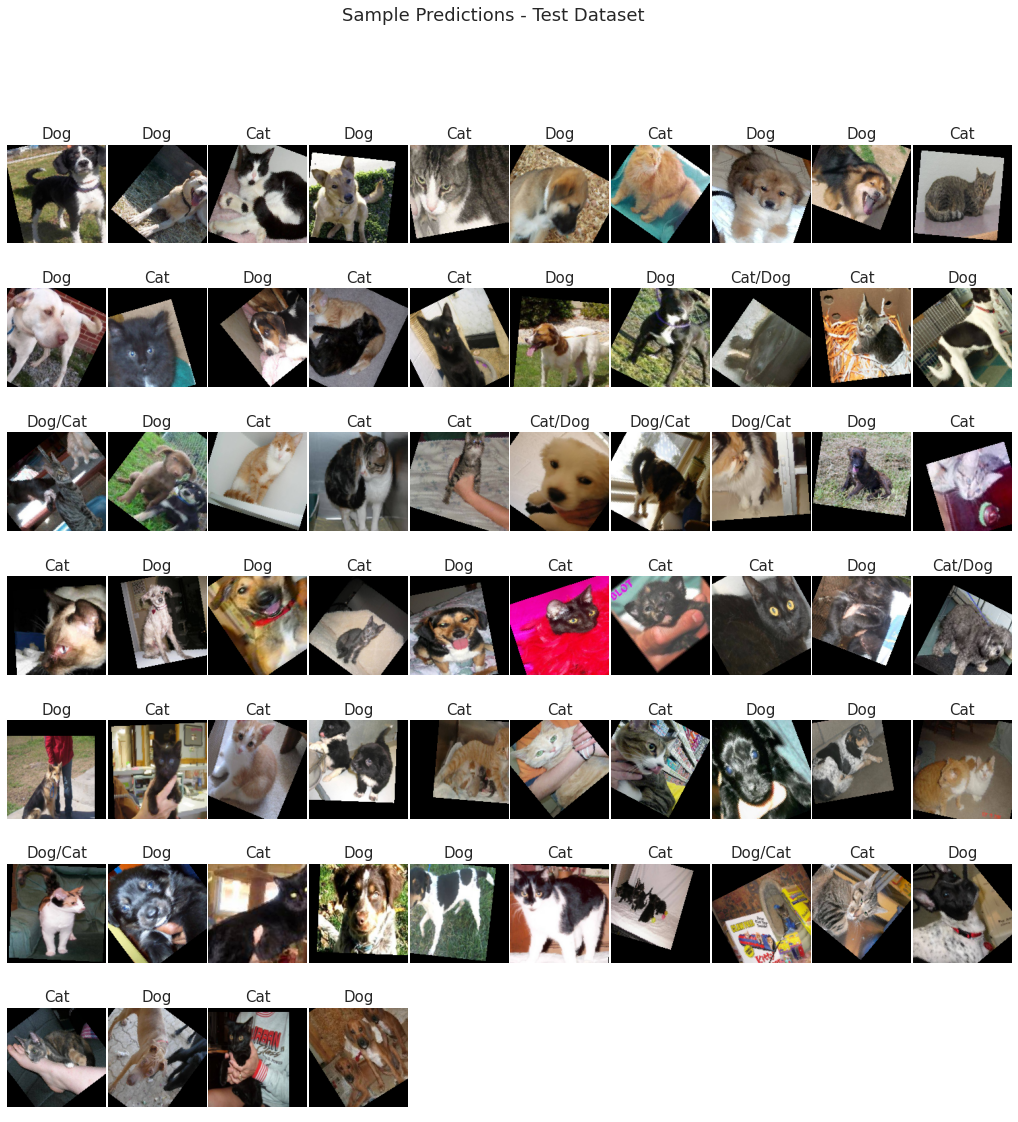

In [ ]:
# display sample
print('Displaying sample predictions...')
trainloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
data_iter = iter(trainloader)
images, labels = data_iter.next()  # fetch a batch of 64 random images
preds = model.predict(images)
preds = np.argmax(preds, axis=1)
#type(images), type(labels), type(preds)
display_sample(images.cpu().numpy(), labels.cpu().numpy(), predictions=preds,
               num_cols=10, plot_title='Sample Predictions - Test Dataset')

## Using VGG16 Pretrained Models
In the preceding section we saw...blah

**NOTE:** this section has been written as an independent section, where we connect to the drive, download data etc.

In [1]:
# We use torchmetrics, which is not installed by default on Collaboratory
!pip install torchmetrics --quiet

     |████████████████████████████████| 419 kB 4.2 MB/s 


In [2]:
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = True

import os

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    gdrive_path = os.path.join(gdrive_mount_point, "My Drive/")
    print('Your Google Drive is mounted at ', gdrive_path)
    COLAB_NOTEBOOKS_PATH = os.path.join(gdrive_path, "Colab Notebooks","Pytorch")
    
    if os.path.exists(COLAB_NOTEBOOKS_PATH):
        print('You Colab notebooks are available at ', COLAB_NOTEBOOKS_PATH)
    
        # display list of files
        #!ls '/content/drive/My Drive/Colab Notebooks/'

        # append our Google Drive folder to module search 
        # **NOTE:** comment this line out if you are NOT running this notebook on Google Colab
        import sys
        #sys.path.append("/content/drive/My Drive/Colab Notebooks/")
        sys.path.append(COLAB_NOTEBOOKS_PATH)
        print('NOTE: {} is appended to sys.path!'.format(COLAB_NOTEBOOKS_PATH))
        # and test it
        import pytorch_toolkit as pytk
        MODEL_SAVE_DIR = os.path.join(COLAB_NOTEBOOKS_PATH, "model_states")
        #IMAGES_ZIP_DIR = "/content/drive/My Drive/Colab Notebooks/data/kaggle/malaria"
    else:
        raise IOError("Unable to mount Google Drive!")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    #IMAGES_ZIP_DIR = "./images/kaggle/malaria"

print(f"Model states will be saved to {MODEL_SAVE_DIR}")
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

Mounted at /content/drive/
Your Google Drive is mounted at  /content/drive/My Drive/
You Colab notebooks are available at  /content/drive/My Drive/Colab Notebooks/Pytorch
NOTE: /content/drive/My Drive/Colab Notebooks/Pytorch is appended to sys.path!
Model states will be saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states


In [3]:
# download the data from Kaggle using Kaggle API
# Run this cell to copy the uploaded kaggle.json file to ~/.kaggle/kaggle.json 
# Kaggle expects the token file to be located here!!
!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/Colab Notebooks/kaggle.json" ~/.kaggle/
# give "me" full access to kaggle.json (i.e. read/write & execute)
!chmod 600 ~/.kaggle/kaggle.json
# confirm that ~/.kaggle folder has kaggle.json file
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d tongpython/cat-and-dog -p /tmp

 96% 209M/218M [00:06<00:00, 44.0MB/s]
100% 218M/218M [00:06<00:00, 37.6MB/s]


In [5]:
!unzip -q -o /tmp/cat-and-dog.zip -d /tmp

In [6]:
TRAIN_IMAGES_BASE_PATH = os.path.join('/tmp', 'training_set', 'training_set')
TEST_IMAGES_BASE_PATH = os.path.join('/tmp', 'test_set', 'test_set')
assert os.path.exists(TRAIN_IMAGES_BASE_PATH), f"FATAL: {TRAIN_IMAGES_BASE_PATH} does not exit!"
assert os.path.exists(TEST_IMAGES_BASE_PATH), f"FATAL: {TEST_IMAGES_BASE_PATH} does not exit!"

### Standard Imports

In [7]:
import warnings

warnings.filterwarnings('ignore')

import sys
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from PIL import Image

# Pytorch imports
import torch
print('Using Pytorch version: ', torch.__version__)
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from torch import optim

# My helper functions for training/evaluating etc.
import pytorch_toolkit as pytk

# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn')
sns.set(style='darkgrid', context='notebook', font_scale=1.20)

SEED = pytk.seed_all()

Using Pytorch version:  1.11.0+cu113


**NOTE:** the `VGG16` pretrained network expects the images to be `(224 x 224)` in size. The image sizes, MODEL_SAVE_NAME & NUM_EPOCHS have been changed below. Rest of the hyper-parameters remain the same as our custom CNN.

In [8]:
# hyper parameters
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 224, 224, 3, 2
NUM_EPOCHS, BATCH_SIZE, LEARNING_RATE, L2_REG = 100, 128, 0.001, 0.001
MODEL_SAVE_NAME = 'cat_or_dog_vgg16.pyt'
MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, MODEL_SAVE_NAME)
print(f"Model state will be saved to {MODEL_SAVE_PATH}")

Model state will be saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/cat_or_dog_vgg16.pyt


**NOTE:** The `means` and `stds` for normalizing images have been added to the transforms below. Otherwise, they are the same as before.

In [9]:
def load_data(test_perc=0.2):
    """
    load the data using datasets API. We also split the test_dataset into 
    cross-val/test datasets using 80:20 ration
    """
    means, stds = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

    xforms = {
        'train': transforms.Compose([
            transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
            transforms.RandomAffine(degrees=(-40, 40), translate=(0.20, 0.20), 
                                    scale=(0.8, 1.2), shear=0.20),
            transforms.RandomHorizontalFlip(0.30),
            transforms.RandomVerticalFlip(0.30),
            transforms.CenterCrop((IMAGE_WIDTH, IMAGE_HEIGHT)),
            transforms.ToTensor(),
            transforms.Normalize(means, stds)
        ]),
        'val_or_test': transforms.Compose([
            transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
            transforms.CenterCrop((IMAGE_WIDTH, IMAGE_HEIGHT)),
            transforms.ToTensor(),
            transforms.Normalize(means, stds)
        ])
    }

    # we'll use Pytorch's ImageFolder dataset
    train_dataset = datasets.ImageFolder(TRAIN_IMAGES_BASE_PATH, transform=xforms['train'])
    test_dataset = datasets.ImageFolder(TEST_IMAGES_BASE_PATH, transform=xforms['val_or_test'])
    num_images = len(test_dataset)
    num_test_images = int(test_perc * num_images)
    num_val_images = num_images - num_test_images
    print(f"get_data(): {len(test_dataset)} test images split to {num_val_images} eval & {num_test_images} test images")
    val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [num_val_images, num_test_images])
    return train_dataset, val_dataset, test_dataset

In [10]:
def display_sample(images, labels, predictions=None, fig_size=None, num_cols=10, plot_title=None):
    num_images = len(images)
    num_rows = num_images // num_cols
    num_rows = num_rows if (num_images % num_cols == 0) else num_rows + 1

    label_lookup = {
        0: 'Cat',
        1: 'Dog'
    }

    figsize = (18,18) if fig_size is None else fig_size

    with sns.axes_style("whitegrid"):
        sns.set(context='notebook', font_scale=1.25)
        sns.set_style({"font.sans-serif": ["SF Pro Display", "Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        # plt.figure(figsize=figsize)
        fig, ax = plt.subplots(num_rows, num_cols, figsize=figsize,
                               gridspec_kw={"wspace": 0.02, "hspace": 0.25}, squeeze=True)
        fig.tight_layout()
        for row in range(num_rows):
            for col in range(num_cols):
                ax[row, col].axis('off')
                index = row * num_cols + col
                if index < num_images:
                    image = images[index].clip(0.0, 255.0)
                    #image = np.transpose(image.astype('uint8'), (1/8, 2/8, 0/8))
                    image = image.transpose((1,2,0))
                    # each channel is divided by 8 to avoid the clipping message
                    ax[row, col].imshow(image)
                    if predictions is not None:
                        title = label_lookup[labels[index]] if predictions[index] == labels[index] \
                            else label_lookup[predictions[index]] + '/' + label_lookup[labels[index]]
                    else:
                        title = label_lookup[labels[index]]
                    ax[row, col].set_title(title)
        if plot_title is not None:
            plt.suptitle(plot_title)

    plt.show()
    plt.close()

In [11]:
# (down)load the data
train_dataset, val_dataset, test_dataset = load_data()
print(f"train_dataset: {len(train_dataset)} images - val_dataset: {len(val_dataset)} images " +
      f"test_dataset: {len(test_dataset)} images.")

get_data(): 2023 test images split to 1619 eval & 404 test images
train_dataset: 8005 images - val_dataset: 1619 images test_dataset: 404 images.


images.shape = torch.Size([64, 3, 224, 224]), labels.shape=torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

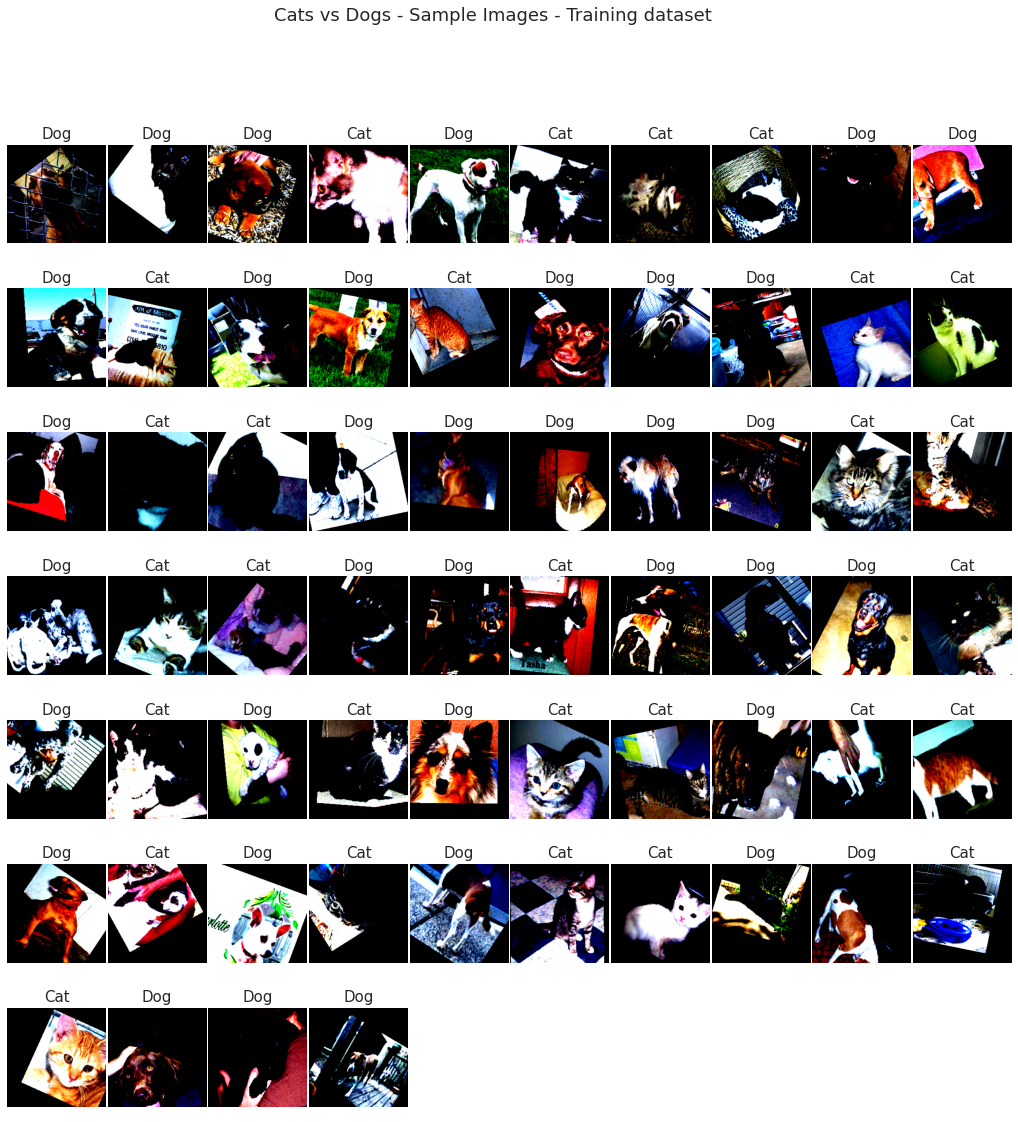

In [12]:
# display a sample
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
data_iter = iter(trainloader)
images, labels = data_iter.next()  # fetch first batch of 64 images & labels
print(f'images.shape = {images.shape}, labels.shape={labels.shape}')
#print(f'labels = {labels[:10]}')
display_sample(images.cpu().numpy(), labels.cpu().numpy(), num_cols=10, 
               plot_title='Cats vs Dogs - Sample Images - Training dataset')

### Downloading model's weights
Here we will download the model & weights

In [13]:
# download model & view it's structure
from torchvision import models
model = models.vgg16(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1


Notice that the VGG16 model is broadly divided into 3 sections:
* The `features` section - combinations of `Conv2d` and `ReLU` layers that detect patterns in the image.
* `AdaptiveAvgPool2d` - which produces a (7 x 7) image
* The `classifier` - the image classification sections.

We want to freeze the `features` layers, and replace the `classifier` section with our own linear classifier. All these operations are done in the `build_model()` function below.

In [14]:
def build_model_vgg(lr=LEARNING_RATE):

    from torchvision import models

    vgg16 = models.vgg16(pretrained=True)
    for param in vgg16.features.parameters():
        param.require_grad = False  # freeze weight

    # replase Avg pool to return a feature map of (1x1)
    # it will auto adjust the filters as required
    vgg16.avgpool = nn.AdaptiveAvgPool2d(output_size=(7,7))

    # our own classifier - only this part will be re-trained
    classifier = nn.Sequential(
        nn.Flatten(),
        # NOTE: classifier.Conv2d layer #28 has 512 filters
        nn.Linear(512 * 7 * 7, 1024),
        nn.ReLU(),
        nn.Dropout(0.20),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.20),
        nn.Linear(512, NUM_CLASSES)
    )
    vgg16.classifier = classifier

    model = pytk.PytkModuleWrapper(vgg16)
    loss_fn = nn.CrossEntropyLoss()  # nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=L2_REG)
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=['acc'])
    return model, optimizer

In [15]:
try:
    del model
except NameError:
    pass

model, optimizer = build_model_vgg()
print(model.summary((NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [16]:
from torch.optim.lr_scheduler import LambdaLR # ExponentialLR, StepLR, CyclicLR
import math
#scheduler = ExponentialLR(optimizer, gamma=0.01)
# scheduler = StepLR(optimizer, step_size=NUM_EPOCHS//5, gamma=0.1)

INITIAL_LR, DROP_RATE, EPOCHS_DROP = 0.5, 0.8, 10.0
def lambda1(epoch): return INITIAL_LR * math.pow(DROP_RATE, math.floor(epoch / EPOCHS_DROP))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)


hist = model.fit_dataset(train_dataset, validation_dataset=val_dataset, epochs=NUM_EPOCHS,
                         batch_size=BATCH_SIZE, lr_scheduler=scheduler, num_workers=5)

Training on GPU...
Training on 8005 samples, cross-validating on 1619 samples
Epoch (  1/100): (8005/8005) -> loss: 0.7294 - acc: 0.5137 - val_loss: 0.6931 - val_acc: 0.5002 - lr: ['0.00050000']
Epoch (  2/100): (8005/8005) -> loss: 0.7096 - acc: 0.5248 - val_loss: 0.6846 - val_acc: 0.5511 - lr: ['0.00050000']
Epoch (  3/100): (8005/8005) -> loss: 0.6980 - acc: 0.5390 - val_loss: 0.6820 - val_acc: 0.5426 - lr: ['0.00050000']
Epoch (  4/100): (8005/8005) -> loss: 0.6823 - acc: 0.5593 - val_loss: 0.6657 - val_acc: 0.5690 - lr: ['0.00050000']
Epoch (  5/100): (8005/8005) -> loss: 0.6683 - acc: 0.5804 - val_loss: 0.6931 - val_acc: 0.5835 - lr: ['0.00050000']
Epoch (  6/100): (8005/8005) -> loss: 0.6606 - acc: 0.5921 - val_loss: 0.6826 - val_acc: 0.5889 - lr: ['0.00050000']
Epoch (  7/100): (8005/8005) -> loss: 0.6467 - acc: 0.6087 - val_loss: 0.6607 - val_acc: 0.6111 - lr: ['0.00050000']
Epoch (  8/100): (8005/8005) -> loss: 0.6340 - acc: 0.6237 - val_loss: 0.6655 - val_acc: 0.6091 - lr: [

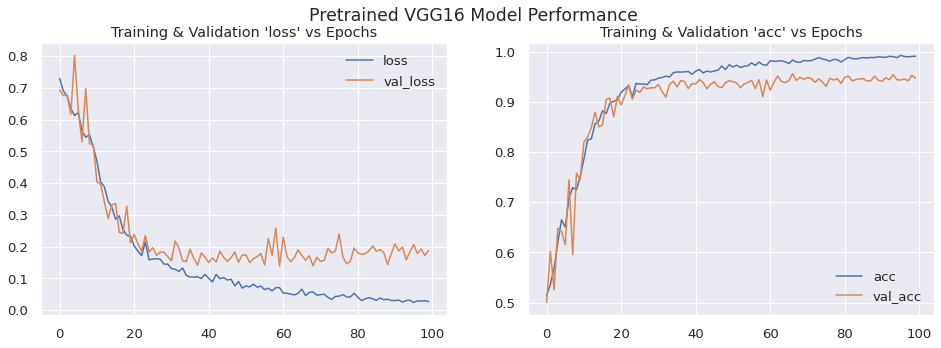

In [17]:
pytk.show_plots(hist, metric='acc', plot_title='Pretrained VGG16 Model Performance')

In [18]:
# evaluate performance
print('Evaluating model performance...')
loss, acc = model.evaluate_dataset(train_dataset)
print(f'  Training dataset -> loss: {loss:.4f} - acc: {acc:.4f}')
loss, acc = model.evaluate_dataset(val_dataset)
print(f'  Cross-val dataset -> loss: {loss:.4f} - acc: {acc:.4f}')
loss, acc = model.evaluate_dataset(test_dataset)
print(f'  Test dataset      -> loss: {loss:.4f} - acc: {acc:.4f}')

Evaluating model performance...
Evaluating (8005/8005) -> loss: 0.0242 - acc: 0.9916
  Training dataset -> loss: 0.0242 - acc: 0.9916
Evaluating (1619/1619) -> loss: 0.1764 - acc: 0.9463
  Cross-val dataset -> loss: 0.1764 - acc: 0.9463
Evaluating (404/404) -> loss: 0.1457 - acc: 0.9598
  Test dataset      -> loss: 0.1457 - acc: 0.9598


### Observations

>Configuration | Training Acc | Cross-val Acc | Test Acc | Observation
>:---|:---:|:---:|:---:|:---|
>**Base Model**|~93-94%|~91-92%|~91-92%| Slightly Overfitting
>**Pre-trained VGG16 Model**|~99-100%|~94-95%|~95-96%%| Overfitting

The model is overfitting the data. You can see from the accuracy curves that the train accuracy diverges slightly from the cross-validation accuracy.

In [19]:
model.save(MODEL_SAVE_PATH)
del model

Pytorch model saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/cat_or_dog_vgg16.pyt


In [20]:
model, optimizer = build_model_vgg()
model.load(MODEL_SAVE_PATH)
print(model.summary((NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

Pytorch model loaded from /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/cat_or_dog_vgg16.pyt
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]            

In [21]:
# run predictions
y_pred, y_true = model.predict_dataset(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
print('Sample labels (50): ', y_true[:50])
print('Sample predictions (50): ', y_true[:50])
print('We got %d/%d incorrect!' % ((y_pred != y_true).sum(), len(y_true)))

Sample labels (50):  [0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 1]
Sample predictions (50):  [0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 1]
We got 15/404 incorrect!


Displaying sample predictions...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

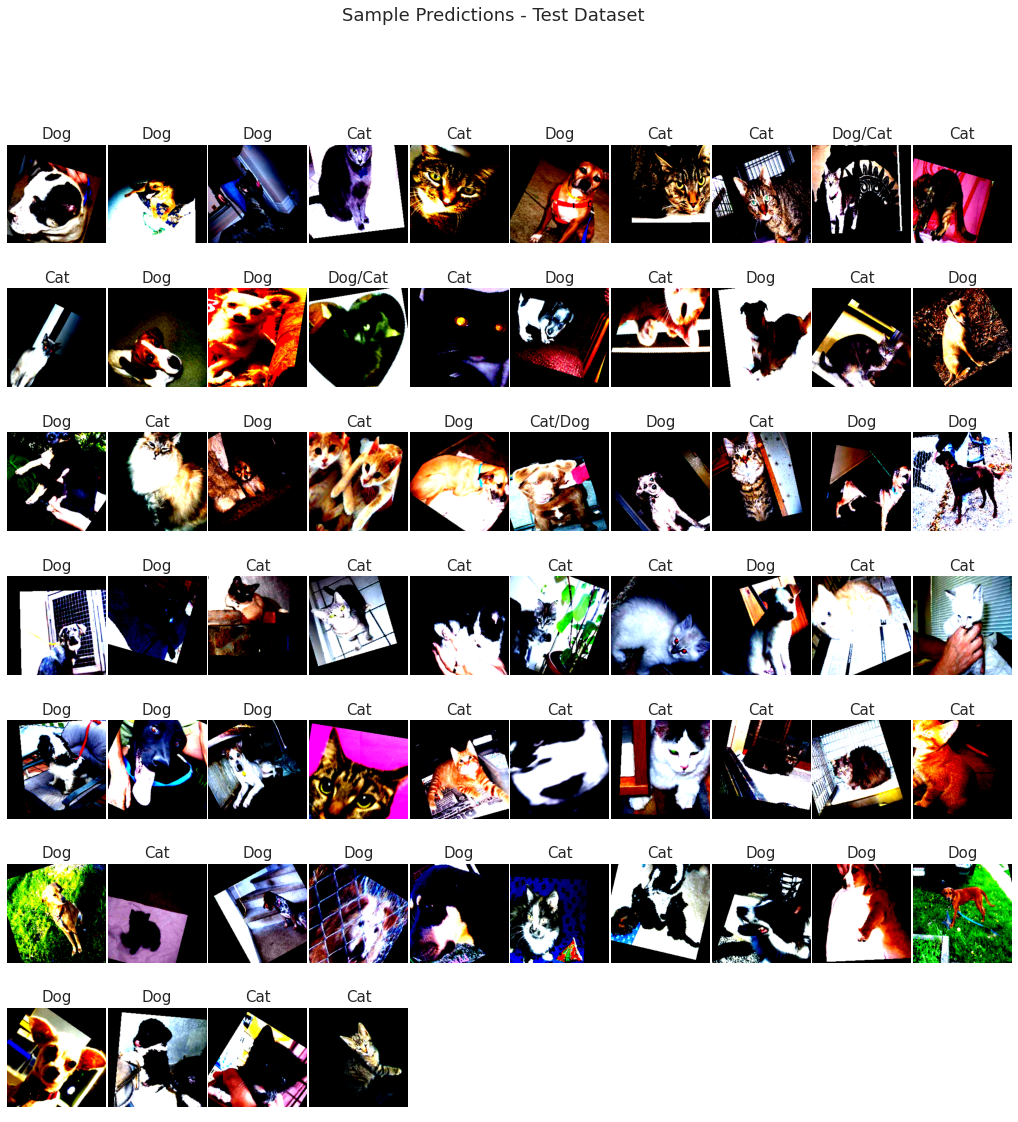

In [22]:
# display sample
print('Displaying sample predictions...')
trainloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
data_iter = iter(trainloader)
images, labels = data_iter.next()  # fetch a batch of 64 random images
preds = model.predict(images)
preds = np.argmax(preds, axis=1)
#type(images), type(labels), type(preds)
display_sample(images.cpu().numpy(), labels.cpu().numpy(), predictions=preds,
               num_cols=10, plot_title='Sample Predictions - Test Dataset')

## Using Resnet18 Pretrained Model
In the preceding section we saw...blah

**NOTE:** this section has been written as an independent section, where we connect to the drive, download data etc.

In [1]:
# We use torchmetrics, which is not installed by default on Collaboratory
!pip install torchmetrics --quiet

     |████████████████████████████████| 419 kB 4.1 MB/s 


In [2]:
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = True

import os

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    gdrive_path = os.path.join(gdrive_mount_point, "My Drive/")
    print('Your Google Drive is mounted at ', gdrive_path)
    COLAB_NOTEBOOKS_PATH = os.path.join(gdrive_path, "Colab Notebooks","Pytorch")
    
    if os.path.exists(COLAB_NOTEBOOKS_PATH):
        print('You Colab notebooks are available at ', COLAB_NOTEBOOKS_PATH)
    
        # display list of files
        #!ls '/content/drive/My Drive/Colab Notebooks/'

        # append our Google Drive folder to module search 
        # **NOTE:** comment this line out if you are NOT running this notebook on Google Colab
        import sys
        #sys.path.append("/content/drive/My Drive/Colab Notebooks/")
        sys.path.append(COLAB_NOTEBOOKS_PATH)
        print('NOTE: {} is appended to sys.path!'.format(COLAB_NOTEBOOKS_PATH))
        # and test it
        import pytorch_toolkit as pytk
        MODEL_SAVE_DIR = os.path.join(COLAB_NOTEBOOKS_PATH, "model_states")
        #IMAGES_ZIP_DIR = "/content/drive/My Drive/Colab Notebooks/data/kaggle/malaria"
    else:
        raise IOError("Unable to mount Google Drive!")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    #IMAGES_ZIP_DIR = "./images/kaggle/malaria"

print(f"Model states will be saved to {MODEL_SAVE_DIR}")
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

Mounted at /content/drive/
Your Google Drive is mounted at  /content/drive/My Drive/
You Colab notebooks are available at  /content/drive/My Drive/Colab Notebooks/Pytorch
NOTE: /content/drive/My Drive/Colab Notebooks/Pytorch is appended to sys.path!
Model states will be saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states


In [3]:
# download the data from Kaggle using Kaggle API
# Run this cell to copy the uploaded kaggle.json file to ~/.kaggle/kaggle.json 
# Kaggle expects the token file to be located here!!
!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/Colab Notebooks/kaggle.json" ~/.kaggle/
# give "me" full access to kaggle.json (i.e. read/write & execute)
!chmod 600 ~/.kaggle/kaggle.json
# confirm that ~/.kaggle folder has kaggle.json file
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d tongpython/cat-and-dog -p /tmp

 96% 209M/218M [00:08<00:00, 27.4MB/s]
100% 218M/218M [00:08<00:00, 28.4MB/s]


In [5]:
!unzip -q -o /tmp/cat-and-dog.zip -d /tmp

In [6]:
TRAIN_IMAGES_BASE_PATH = os.path.join('/tmp', 'training_set', 'training_set')
TEST_IMAGES_BASE_PATH = os.path.join('/tmp', 'test_set', 'test_set')
assert os.path.exists(TRAIN_IMAGES_BASE_PATH), f"FATAL: {TRAIN_IMAGES_BASE_PATH} does not exit!"
assert os.path.exists(TEST_IMAGES_BASE_PATH), f"FATAL: {TEST_IMAGES_BASE_PATH} does not exit!"

### Standard Imports

In [7]:
import warnings

warnings.filterwarnings('ignore')

import sys
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from PIL import Image

# Pytorch imports
import torch

print('Using Pytorch version: ', torch.__version__)
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from torch import optim

# My helper functions for training/evaluating etc.
import pytorch_toolkit as pytk

# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn')
sns.set(style='darkgrid', context='notebook', font_scale=1.20)

SEED = pytk.seed_all()

Using Pytorch version:  1.11.0+cu113


**NOTE:** the `Resnet18` pretrained network expects the images to be `(224 x 224)` in size. The image sizes & MODEL_SAVE_NAME & NUM_EPOCHS have been changed below. Rest of the hyper-parameters remain the same.

In [8]:
# hyper parameters
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 224, 224, 3, 2
NUM_EPOCHS, BATCH_SIZE, LEARNING_RATE, L2_REG = 100, 128, 0.001, 0.003
MODEL_SAVE_NAME = 'cat_or_dog_resnet18.pyt'
MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, MODEL_SAVE_NAME)
print(f"Model state will be saved to {MODEL_SAVE_PATH}")

Model state will be saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/cat_or_dog_resnet18.pyt


**NOTE:** The `means` and `stds` for normalizing images have been added to the transforms below. Otherwise, they are the same as before.

In [9]:
def load_data(test_perc=0.2):
    """
    load the data using datasets API. We also split the test_dataset into 
    cross-val/test datasets using 80:20 ration
    """
    means, stds = [0.485,0.456, 0.406], [0.229, 0.224, 0.225]

    xforms = {
        'train': transforms.Compose([
            transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
            transforms.RandomAffine(degrees=(-40, 40), translate=(0.20, 0.20), 
                                    scale=(0.8, 1.2), shear=0.20),
            transforms.RandomHorizontalFlip(0.30),
            transforms.RandomVerticalFlip(0.30),
            transforms.CenterCrop((IMAGE_WIDTH, IMAGE_HEIGHT)),
            transforms.ToTensor(),
            transforms.Normalize(means, stds)
        ]),
        'val_or_test': transforms.Compose([
            transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
            transforms.CenterCrop((IMAGE_WIDTH, IMAGE_HEIGHT)),
            transforms.ToTensor(),
            transforms.Normalize(means, stds)
        ])
    }

    # we'll use Pytorch's ImageFolder dataset
    train_dataset = datasets.ImageFolder(TRAIN_IMAGES_BASE_PATH, transform=xforms['train'])
    test_dataset = datasets.ImageFolder(TEST_IMAGES_BASE_PATH, transform=xforms['train'])
    num_images = len(test_dataset)
    num_test_images = int(test_perc * num_images)
    num_val_images = num_images - num_test_images
    print(f"get_data(): {len(test_dataset)} test images split to {num_val_images} eval & {num_test_images} test images")
    val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [num_val_images, num_test_images])
    return train_dataset, val_dataset, test_dataset

In [10]:
def display_sample(images, labels, predictions=None, fig_size=None, num_cols=10, plot_title=None):
    num_images = len(images)
    num_rows = num_images // num_cols
    num_rows = num_rows if (num_images % num_cols == 0) else num_rows + 1

    label_lookup = {
        0: 'Cat',
        1: 'Dog'
    }

    figsize = (18,18) if fig_size is None else fig_size

    with sns.axes_style("whitegrid"):
        sns.set(context='notebook', font_scale=1.25)
        sns.set_style({"font.sans-serif": ["SF Pro Display", "Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        # plt.figure(figsize=figsize)
        fig, ax = plt.subplots(num_rows, num_cols, figsize=figsize,
                               gridspec_kw={"wspace": 0.02, "hspace": 0.25}, squeeze=True)
        fig.tight_layout()
        for row in range(num_rows):
            for col in range(num_cols):
                ax[row, col].axis('off')
                index = row * num_cols + col
                if index < num_images:
                    image = images[index].clip(0.0, 255.0)
                    #image = np.transpose(image.astype('uint8'), (1/8, 2/8, 0/8))
                    image = image.transpose((1,2,0))
                    # each channel is divided by 8 to avoid the clipping message
                    ax[row, col].imshow(image)
                    if predictions is not None:
                        title = label_lookup[labels[index]] if predictions[index] == labels[index] \
                            else label_lookup[predictions[index]] + '/' + label_lookup[labels[index]]
                    else:
                        title = label_lookup[labels[index]]
                    ax[row, col].set_title(title)
        if plot_title is not None:
            plt.suptitle(plot_title)

    plt.show()
    plt.close()

In [11]:
# (down)load the data
train_dataset, val_dataset, test_dataset = load_data()
print(f"train_dataset: {len(train_dataset)} images - val_dataset: {len(val_dataset)} images " +
      f"test_dataset: {len(test_dataset)} images.")

get_data(): 2023 test images split to 1619 eval & 404 test images
train_dataset: 8005 images - val_dataset: 1619 images test_dataset: 404 images.


images.shape = torch.Size([64, 3, 224, 224]), labels.shape=torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

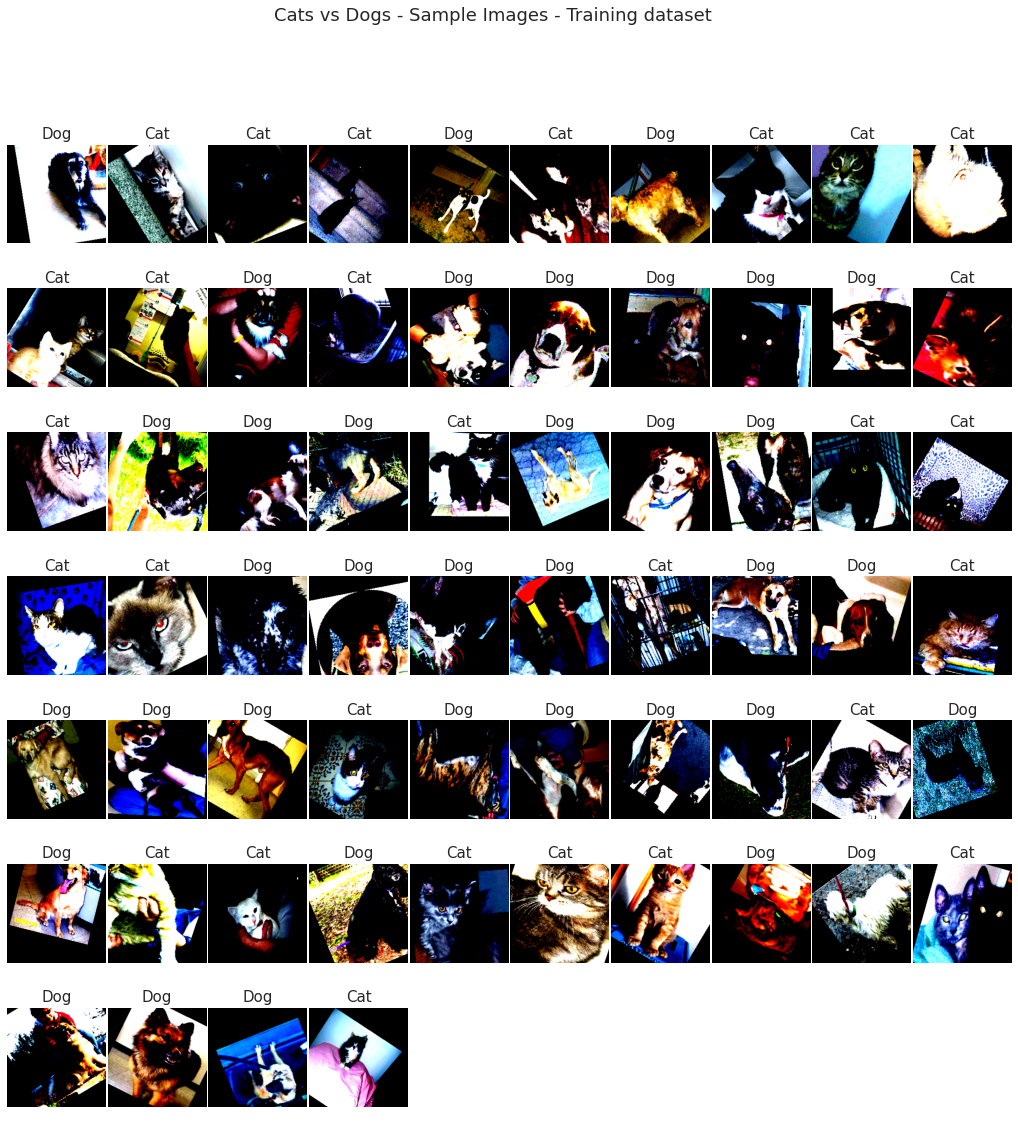

In [12]:
# display a sample
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
data_iter = iter(trainloader)
images, labels = data_iter.next()  # fetch first batch of 64 images & labels
print(f'images.shape = {images.shape}, labels.shape={labels.shape}')
#print(f'labels = {labels[:10]}')
display_sample(images.cpu().numpy(), labels.cpu().numpy(), num_cols=10, 
               plot_title='Cats vs Dogs - Sample Images - Training dataset')

### Downloading the model's weights
Here we will download the model & weights

In [13]:
# download model & view it's structure
from torchvision import models
model = models.resnet18(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  


As with the VGG16 mode, we want to:
* Freeze all the layers
* Replace the `fc` layer with our Liner model

We'll combine this into the `build_model_resnet()` function below.

In [14]:
def build_model_resnet(lr=LEARNING_RATE):

    from torchvision import models

    resnet = models.resnet18(pretrained=True)
    for param in resnet.parameters():
        param.require_grad = False  # freeze weights

    # replase Avg pool to return a feature map of (1x1)
    # it will auto adjust the filters as required
    resnet.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

    # our own classifier - only this part will be re-trained
    classifier = nn.Sequential(
        nn.Flatten(),
        # NOTE: classifier.Conv2d layer #28 has 512 filters
        nn.Linear(512 * 1 * 1, 1024),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(512, NUM_CLASSES)
    )
    resnet.fc = classifier

    model = pytk.PytkModuleWrapper(resnet)
    loss_fn = nn.CrossEntropyLoss()  # nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=L2_REG)
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=['acc'])
    return model, optimizer

In [15]:
try:
    del model
except NameError:
    pass

model, optimizer = build_model_resnet()
print(model.summary((NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [16]:
from torch.optim.lr_scheduler import LambdaLR # ExponentialLR, StepLR, CyclicLR
import math
#scheduler = ExponentialLR(optimizer, gamma=0.01)
# scheduler = StepLR(optimizer, step_size=NUM_EPOCHS//5, gamma=0.1)

INITIAL_LR, DROP_RATE, EPOCHS_DROP = 0.5, 0.8, 10.0
def lambda1(epoch): return INITIAL_LR * math.pow(DROP_RATE, math.floor(epoch / EPOCHS_DROP))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)


hist = model.fit_dataset(train_dataset, validation_dataset=val_dataset, epochs=NUM_EPOCHS,
                         batch_size=BATCH_SIZE, lr_scheduler=scheduler, num_workers=5)

Training on GPU...
Training on 8005 samples, cross-validating on 1619 samples
Epoch (  1/100): (8005/8005) -> loss: 0.2113 - acc: 0.9120 - val_loss: 0.1906 - val_acc: 0.9169 - lr: ['0.00050000']
Epoch (  2/100): (8005/8005) -> loss: 0.1794 - acc: 0.9257 - val_loss: 0.1830 - val_acc: 0.9213 - lr: ['0.00050000']
Epoch (  3/100): (8005/8005) -> loss: 0.1715 - acc: 0.9302 - val_loss: 0.1800 - val_acc: 0.9258 - lr: ['0.00050000']
Epoch (  4/100): (8005/8005) -> loss: 0.1683 - acc: 0.9317 - val_loss: 0.1871 - val_acc: 0.9257 - lr: ['0.00050000']
Epoch (  5/100): (8005/8005) -> loss: 0.1691 - acc: 0.9317 - val_loss: 0.1952 - val_acc: 0.9220 - lr: ['0.00050000']
Epoch (  6/100): (8005/8005) -> loss: 0.1667 - acc: 0.9326 - val_loss: 0.2158 - val_acc: 0.9072 - lr: ['0.00050000']
Epoch (  7/100): (8005/8005) -> loss: 0.1659 - acc: 0.9328 - val_loss: 0.2117 - val_acc: 0.9101 - lr: ['0.00050000']
Epoch (  8/100): (8005/8005) -> loss: 0.1645 - acc: 0.9335 - val_loss: 0.2162 - val_acc: 0.9075 - lr: [

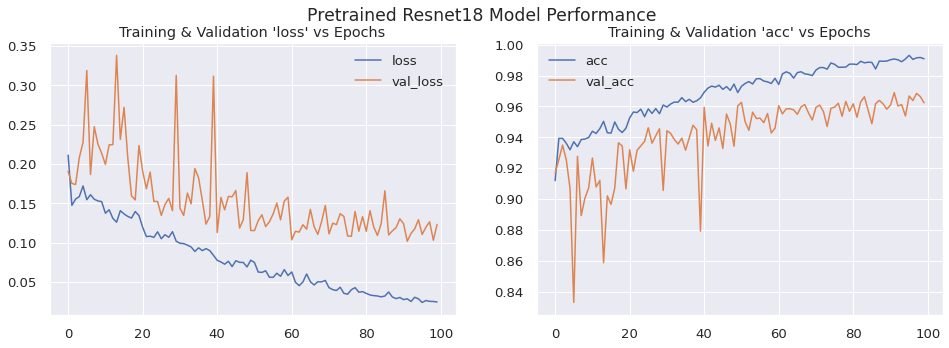

In [17]:
pytk.show_plots(hist, metric='acc', plot_title='Pretrained Resnet18 Model Performance')

In [18]:
# evaluate performance
print('Evaluating model performance...')
loss, acc = model.evaluate_dataset(train_dataset)
print(f'  Training dataset -> loss: {loss:.4f} - acc: {acc:.4f}')
loss, acc = model.evaluate_dataset(val_dataset)
print(f'  Cross-val dataset -> loss: {loss:.4f} - acc: {acc:.4f}')
loss, acc = model.evaluate_dataset(test_dataset)
print(f'  Test dataset      -> loss: {loss:.4f} - acc: {acc:.4f}')

Evaluating model performance...
Evaluating (8005/8005) -> loss: 0.0181 - acc: 0.9945
  Training dataset -> loss: 0.0181 - acc: 0.9945
Evaluating (1619/1619) -> loss: 0.1173 - acc: 0.9661
  Cross-val dataset -> loss: 0.1173 - acc: 0.9661
Evaluating (404/404) -> loss: 0.0822 - acc: 0.9710
  Test dataset      -> loss: 0.0822 - acc: 0.9710


### Observations

>Configuration | Training Acc | Cross-val Acc | Test Acc | Observation
>:---|:---:|:---:|:---:|:---|
>**Base Model**|~93-94%|~91-92%|~91-92%| Slightly Overfitting
>**Pre-trained VGG16 Model**|~99-100%|~94-95%|~95-96%%| Overfitting
>**Pre-trained Resnet18 Model**|~99-100%|~96-97%|~98-99%%| Slight Overfitting

Notice that the Resnet18 model is slightly overfitting the data. However, in terms of performance, it is still the best model, with 98-99% test accuracy!

In [19]:
model.save(MODEL_SAVE_PATH)
del model

Pytorch model saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/cat_or_dog_resnet18.pyt


In [20]:
model, optimizer = build_model_resnet()
model.load(MODEL_SAVE_PATH)
print(model.summary((NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

Pytorch model loaded from /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/cat_or_dog_resnet18.pyt
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]         

In [21]:
# run predictions
y_pred, y_true = model.predict_dataset(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
print('Sample labels (50): ', y_true[:50])
print('Sample predictions (50): ', y_true[:50])
print('We got %d/%d incorrect!' % ((y_pred != y_true).sum(), len(y_true)))

Sample labels (50):  [0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0]
Sample predictions (50):  [0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0]
We got 18/404 incorrect!


Displaying sample predictions...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

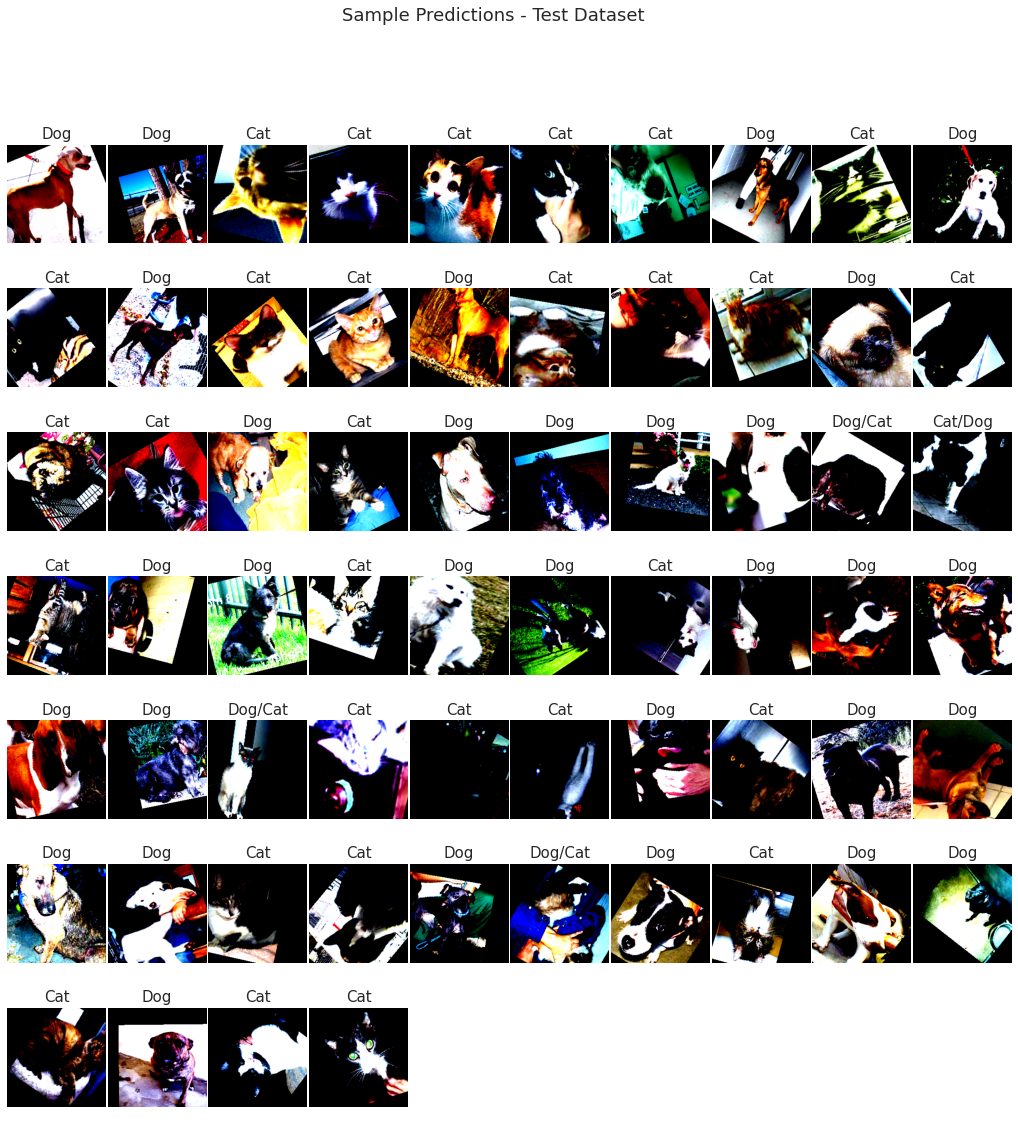

In [22]:
# display sample
print('Displaying sample predictions...')
trainloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
data_iter = iter(trainloader)
images, labels = data_iter.next()  # fetch a batch of 64 random images
preds = model.predict(images)
preds = np.argmax(preds, axis=1)
#type(images), type(labels), type(preds)
display_sample(images.cpu().numpy(), labels.cpu().numpy(), predictions=preds,
               num_cols=10, plot_title='Sample Predictions - Test Dataset')

# <center> -- END -- </center>